In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#Hyper Parameters
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28
INPUT_SIZE = 28
LR = 0.01
DOWNLOAD_MNIST = True

In [3]:
train_data  = dsets.MNIST(root='./mnist',train=True,transform=transforms.ToTensor(),download=DOWNLOAD_MNIST)


Extracting ./mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./mnist\MNIST\raw
Extracting ./mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist\MNIST\raw

Extracting ./mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist\MNIST\raw
Extracting ./mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist\MNIST\raw
Processing...
Done!


D:\software\anaconda\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([60000, 28, 28])
torch.Size([60000])


D:\software\anaconda\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
D:\software\anaconda\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


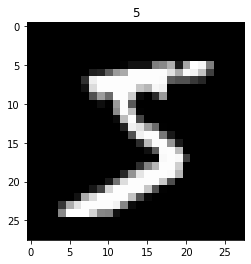

In [4]:
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255 #shape(2000,28,28) value in (0,1)
test_y = test_data.test_labels.numpy()[:2000]

D:\software\anaconda\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\software\anaconda\envs\tensorflow\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [12]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=64,
            num_layers=1,
            batch_first=True, # true [batch, time_step, input] false [time_step,batch, input]
        )
        self.out = nn.Linear(64,10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        #None represents zero initial hidden state
        r_out,(h_n,h_c) = self.rnn(x, None) # x[batch,time_step,input_size]

        # choose r_out at the last time step
        # out  = self.out[r_out[:,-1,:]]
        out = self.out(r_out[:, -1, :])
        return out

In [13]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
optimizer = torch.optim.Adam(rnn.parameters(),lr=LR)
loss_func = nn.CrossEntropyLoss()# the target label is not one-hotted

for epoch in range(EPOCH):
    for step, (x, y ) in enumerate(train_loader):
        #(-1,28,28)根据另外两个维度自动推
        b_x = x.view(-1,28,28) # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)
        loss = loss_func(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 50 ==0:
            test_out = rnn(test_x)
            pre_y = torch.max(test_out, 1)[1].data.numpy().squeeze()
            accuracy = sum(pre_y == test_y) / test_y.size
            print('Epoch: ',epoch,'| train loss: %.4f' % loss.data.numpy(),'| test accuracy: %.2f' % accuracy)

Epoch:  0 | train loss: 2.3124 | test accuracy: 0.12
Epoch:  0 | train loss: 1.1475 | test accuracy: 0.56
Epoch:  0 | train loss: 0.7210 | test accuracy: 0.70
Epoch:  0 | train loss: 0.6055 | test accuracy: 0.80
Epoch:  0 | train loss: 0.4439 | test accuracy: 0.87
Epoch:  0 | train loss: 0.4068 | test accuracy: 0.86
Epoch:  0 | train loss: 0.3595 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1218 | test accuracy: 0.93
Epoch:  0 | train loss: 0.4024 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2750 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0951 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1027 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1215 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0722 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2007 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2042 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1083 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0425 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0236 | test accuracy

In [15]:
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
